In [5]:
from tqdm import tqdm
%pip install genism
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import gensim
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import word2vec

wn = WordNetLemmatizer()

ERROR: Could not find a version that satisfies the requirement genism (from versions: none)
ERROR: No matching distribution found for genism
Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/arjunrajpal/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/arjunrajpal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/arjunrajpal/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [16]:
import pandas as pd
df = pd.read_csv('./data/labeled_headlines_10k.csv')
df.head()
display(df.columns)

X_train, X_test, y_train, y_test = train_test_split(df['title'], df['Predicted_Sentiment'], test_size=0.2, random_state=42)

Index(['title', 'link', 'date', 'source', 'country', 'language',
       'translated_title', 'number_of_characters_title',
       'number_of_words_title', 'day_of_week', 'month', 'year', 'quarter',
       'is_weekend', 'is_holiday', 'source_type', 'final_redirected_URL',
       'domain_of_URL', 'subdomain_of_URL', 'URL_depth', 'top_level_domain',
       'url_length', 'author', 'cleaned_title', 'dominant_topic',
       'Predicted_Sentiment'],
      dtype='object')

In [17]:
%pip install nltk
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))


def preprocess_text(text):
    tokens = word_tokenize(text)
    # Remove punctuation and numbers
    table = str.maketrans('', '', string.punctuation + string.digits)
    tokens = [word.translate(table) for word in tokens]
    tokens = [token for token in tokens if token.lower() not in ['artificial', 'ai', 'intelligence'] and token not in stop_words and token not in string.punctuation]
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    tokens = [word for word in tokens if len(word) > 2]
    title_string = ' '.join(df['title'])
    return title_string

Note: you may need to restart the kernel to use updated packages.


In [20]:

model = word2vec.Word2Vec(X_train, vector_size=100, min_count=1, workers=4)

model.train(X_train, total_words=100, epochs=10)
train_vectors = preprocess_text(X_train)
test_vectors = preprocess_text(X_train)
print(train_vectors)
train_labels = y_train.apply(lambda x: 1 if x == 'positive' else 0)
test_labels = y_test.apply(lambda x: 1 if x == 'positive' else 0)

lr = LogisticRegression(random_state=42)
lr.fit(train_vectors, train_labels)
val_preds = lr.predict(test_vectors)
val_acc = accuracy_score(test_labels, val_preds)
val_f1 = f1_score(test_labels, val_preds, average='weighted')
val_precision = precision_score(test_labels, val_preds, average='weighted')
val_recall = recall_score(test_labels, val_preds, average='weighted')

print("IMDB - W2V Model - Logistic Regression Results:")
print("Accuracy: {:.4f}".format(val_acc))
print("F1 Score: {:.4f}".format(val_f1))
print("Precision: {:.4f}".format(val_precision))
print("Recall: {:.4f}".format(val_recall))

svm = SVC(random_state=42)
svm.fit(train_vectors, train_labels)
val_preds = svm.predict(test_labels)
val_acc = accuracy_score(test_labels, val_preds)
val_f1 = f1_score(test_labels, val_preds, average='weighted')
val_precision = precision_score(test_labels, val_preds, average='weighted')
val_recall = recall_score(test_labels, val_preds, average='weighted')

print("IMDB - W2V Model - SVM Results:")
print("Accuracy: {:.4f}".format(val_acc))
print("F1 Score: {:.4f}".format(val_f1))
print("Precision: {:.4f}".format(val_precision))
print("Recall: {:.4f}".format(val_recall))

TypeError: expected string or bytes-like object, got 'Series'

In [108]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, drop_prob=0.5):
        super(LSTMModel, self).__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        batch_size = x.size(0)
        embeds = self.embedding(x)
        lstm_out, _ = self.lstm(embeds)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)

        out = self.dropout(lstm_out)
        out = self.fc(out)
        out = self.sigmoid(out)

        out = out.view(batch_size, -1)
        out = out[:,-1]
        return out

model = LSTMModel(vocab_size, embedding_dim, hidden_dim=256, output_dim=1, n_layers=2)

'''
Topic 0: 0.013*"generative" + 0.010*"new" + 0.007*"help" + 0.007*"launch" + 0.005*"tool" + 0.005*"aipowered" + 0.005*"make" + 0.005*"enterprise" + 0.005*"chatbots" + 0.005*"platform"
Topic 1: 0.060*"artificial" + 0.058*"intelligence" + 0.009*"generative" + 0.009*"chatbot" + 0.007*"musk" + 0.006*"human" + 0.006*"use" + 0.005*"risk" + 0.005*"elon" + 0.005*"say"
Topic 2: 0.031*"artificial" + 0.030*"intelligence" + 0.011*"new" + 0.010*"chatbot" + 0.010*"generative" + 0.010*"stock" + 0.009*"gpt" + 0.007*"launch" + 0.007*"chat" + 0.007*"expert"
Topic 3: 0.022*"model" + 0.012*"gpt" + 0.010*"new" + 0.009*"chatbot" + 0.009*"language" + 0.008*"open" + 0.008*"llm" + 0.007*"generative" + 0.007*"large" + 0.006*"market"
Topic 4: 0.025*"generative" + 0.012*"google" + 0.011*"meta" + 0.011*"new" + 0.010*"intelligence" + 0.009*"chatbot" + 0.009*"artificial" + 0.008*"tool" + 0.007*"launch" + 0.007*"model"
'''

In [109]:
# Define loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())

# Number of training epochs
epochs = 10

# Move model to GPU if available
if torch.cuda.is_available():
    model = model.cuda()

# Training loop
for epoch in range(epochs):
    for inputs, labels in train_loader:
        # Move inputs and labels to GPU if available
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        # Compute loss
        loss = criterion(outputs.squeeze(), labels.float())
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    print(f'Epoch: {epoch+1}/{epochs}... Loss: {loss.item()}')

KeyError: 2770

Duplicate key in file '/Users/arjunrajpal/.matplotlib/matplotlibrc', line 2 ('backend: TkAgg')


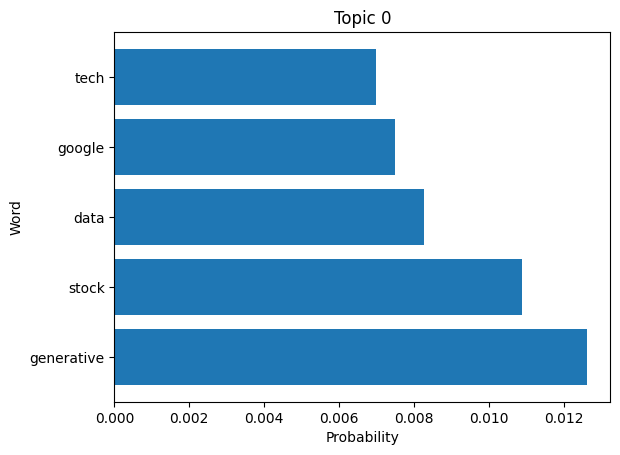

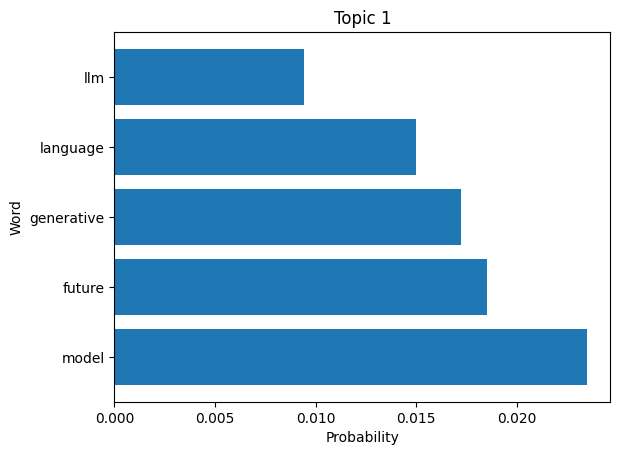

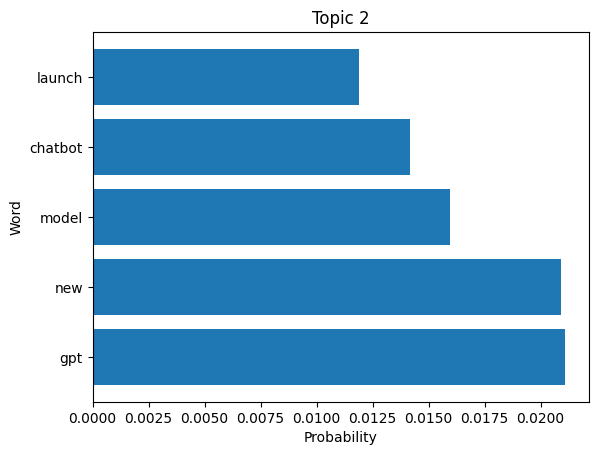

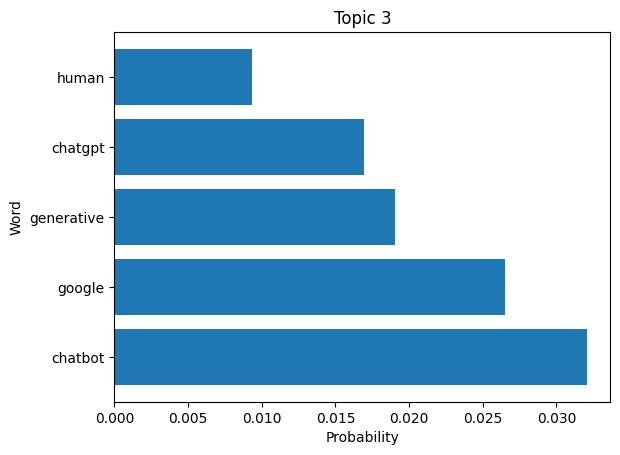

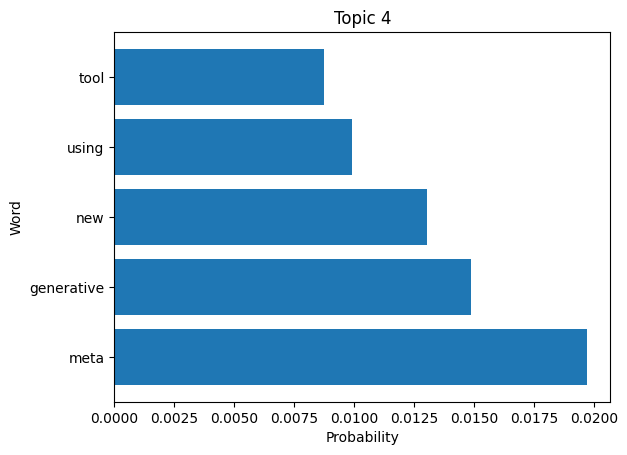

In [ ]:
import matplotlib.pyplot as plt

def visualize_topics(lda_model):
    topics = lda_model.show_topics(num_topics=10, num_words=5, formatted=False)
    for topic_idx, topic_words in topics:
        words = [word[0] for word in topic_words]
        probabilities = [word[1] for word in topic_words]
        plt.barh(words, probabilities)
        plt.title(f"Topic {topic_idx}")
        plt.xlabel("Probability")
        plt.ylabel("Word")
        plt.show()

# Visualize the topics
visualize_topics(model)

In [ ]:
%pip install pyLDAvis

import pandas as pd
import pyLDAvis
import pyLDAvis.gensim

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
vis

  Using cached setuptools-69.1.1-py3-none-any.whl.metadata (6.2 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 5.0 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 6.9 MB/s eta 0:00:0000:010:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.9/91.9 kB 9.7 MB/s eta 0:00:00
Using cached setuptools-69.1.1-py3-none-any.whl (819 kB)
Note: you may need to restart the kernel to use updated packages.


/Users/arjunrajpal/Documents/GitHub/datathon-breaking-bad-data/.venv/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=57870) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/Users/arjunrajpal/Documents/GitHub/datathon-breaking-bad-data/.venv/lib/python3.12/site-packages/joblib/_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
/Users/arjunrajpal/Documents/GitHub/datathon-breaking-bad-data/.venv/lib/python3.12/site-packages/joblib/_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
/Users/arjunrajpal/Documents/GitHub/datathon-breaking-bad-data/.venv/lib/python3.12/site-packages/joblib/_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.141197 -0.082311       1        1  23.641092
2      0.024183 -0.143459       2        1  22.880191
1     -0.244096 -0.003866       3        1  18.312096
4      0.017716 -0.003232       4        1  18.225161
0      0.061000  0.232868       5        1  16.941460, topic_info=           Term        Freq       Total Category  logprob  loglift
163     chatbot  667.000000  667.000000  Default  30.0000  30.0000
32       google  462.000000  462.000000  Default  29.0000  29.0000
90        model  512.000000  512.000000  Default  28.0000  28.0000
1101       meta  221.000000  221.000000  Default  27.0000  27.0000
134      future  209.000000  209.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
27       launch   50.765464  368.495648   Topic5  -5.3224  -0.2068
474         big   36.090828   87.185368   Topic5  -5.6636   0.8934
43    assistant   35.459911   96.691867   Topic5  -5.6812   0.7723
743         say   37.455789  210.061127   Topic5  -5.6265   0.0512
36      startup   35.103174  138.338227   Topic5  -5.6914   0.4040

[312 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
3554      1  0.975493       across
2127      3  0.988286          add
1295      4  0.984074        adobe
2403      5  0.980929          age
277       5  0.995110  aigenerated
...     ...       ...          ...
74        3  0.172595        world
74        4  0.262645        world
74        5  0.375207        world
2489      4  0.977861       writer
1391      4  0.968995         zoom

[435 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 2, 5, 1])

/opt/homebrew/Cellar/python@3.12/3.12.2_1/Frameworks/Python.framework/Versions/3.12/lib/python3.12/pty.py:95: DeprecationWarning: This process (pid=57870) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.4/169.4 kB 8.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


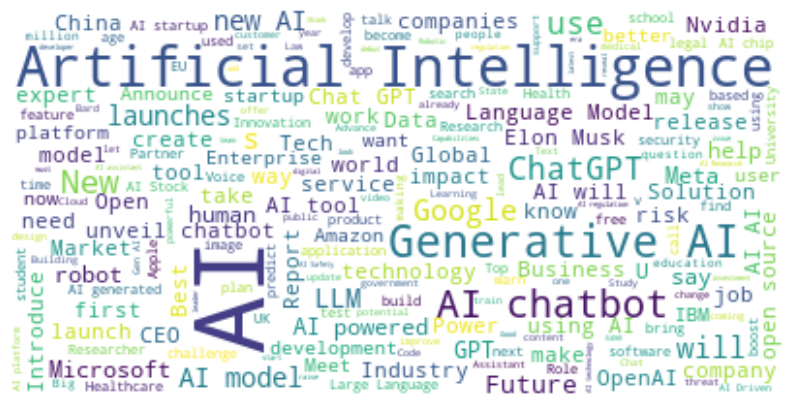

In [ ]:
%pip install wordcloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
sw = STOPWORDS


text = " ".join(i for i in df['cleaned_title'])
wc2 = WordCloud(stopwords=sw, background_color="white", max_words=300).generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wc2, interpolation="bilinear")
plt.axis("off")
plt.show()